# Prepare custom dataset

In [39]:
# Copyright 2021 wngfra.
# SPDX-License-Identifier: Apache-2.0

import glob
import os
import re
import numpy as np
from bidict import bidict
from numpy.lib.stride_tricks import sliding_window_view
from torch.utils.data import Dataset
from torchvision import transforms

class Texture:
    """ Create a bidict from a texture name list."""

    def __init__(self, texture_names):
        self.texture_by_id = bidict()
        for i, tn in enumerate(set(texture_names)):
            self.texture_by_id[tn] = i

    def get_id(self, texture_name: str):
        return self.texture_by_id[texture_name]

    def get_name(self, texture_id: int):
        return self.texture_by_id.inverse[texture_id]


class TacDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.filelist = [y for x in os.walk(
            root_dir) for y in glob.glob(os.path.join(x[0], '*.csv'))]
        self.params = [(0.0, 0.0)] * len(self.filelist)
        self.texture_names = []
        for i, filename in enumerate(self.filelist):
            basename = os.path.basename(filename)
            namegroups = basename.split('_')

            self.texture_names.append(namegroups[0])
            self.params[i] = [int(re.search(r"\d+", namegroups[1]).group(0)),
                              float(re.search(r"[-+]?\d+", namegroups[2]).group(0))]
        self.textures = Texture(self.texture_names)

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, index):
        filename = self.filelist[index]
        rawdata  = np.genfromtxt(filename, delimiter=',', skip_header=1)
        tacdata  = rawdata[:, 3:]
        texture_name = self.texture_names[index]
        if self.transform:
            tacdata = self.transform(tacdata)
        return tacdata, self.params[index], self.textures.get_id(texture_name)
    
    def count_class(self):
        return len(set(self.texture_names))

    def get_texture_name(self, texture_id):
        return self.textures.get_name(texture_id)

    
""" Custom transforms """

class Normalize(object):
    def __init__(self, axis=0):
        self.axis = axis

    def __call__(self, sample):
        return (sample - np.mean(sample, keepdims=True)) / np.std(sample, keepdims=True)
    
def fft_resample(x):
    axis = 0
    
    x = np.asarray(x)
    Nx = x.shape[axis]
    
    X = rfft(x, axis=axis, norm="ortho")
    
    # Placeholder array for output spectrum
    newshape = list(x.shape)
    newshape[0] = num // 2 + 1
    Y = np.zeros(newshape, X.dtype)

    # Copy positive frequency components (and Nyquist, if present)
    N = min(num, Nx)
    nyq = N // 2 + 1  # Slice index that includes Nyquist if present
    sl = [slice(None)] * x.ndim
    sl[axis] = slice(0, nyq)
    Y[tuple(sl)] = X[tuple(sl)]

    # Split/join Nyquist component(s) if present
    # So far we have set Y[+N/2]=X[+N/2]
    if N % 2 == 0:
        if num < Nx:  # downsampling
            sl[axis] = slice(N//2, N//2 + 1)
            Y[tuple(sl)] *= 2.
        elif Nx < num:  # upsampling
            # select the component at frequency +N/2 and halve it
            sl[axis] = slice(N//2, N//2 + 1)
            Y[tuple(sl)] *= 0.5
    
    Ys = np.abs(Y)[1:, :].flatten()
    return Ys

transform = transforms.Compose([Normalize(axis=1)])
ds = TacDataset('data', transform=transform)

# Figures for writing docs

<IPython.core.display.Javascript object>


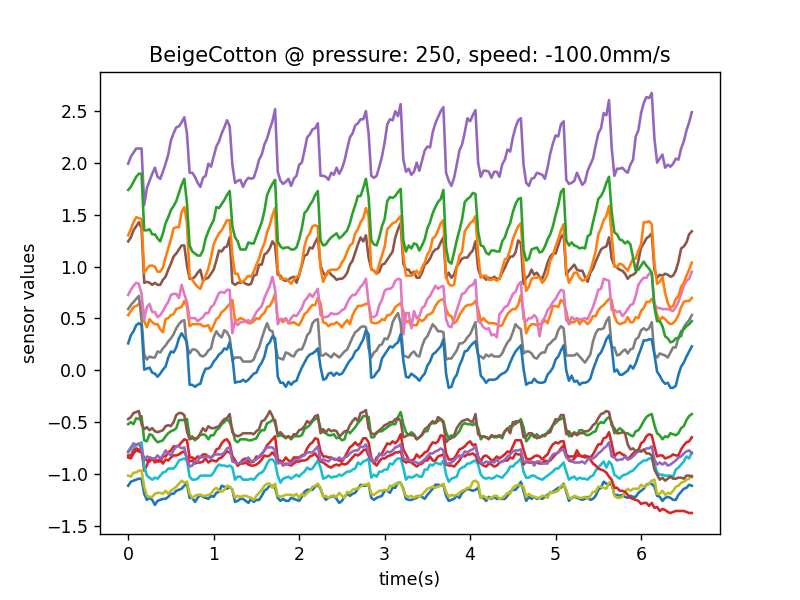

<IPython.core.display.Javascript object>


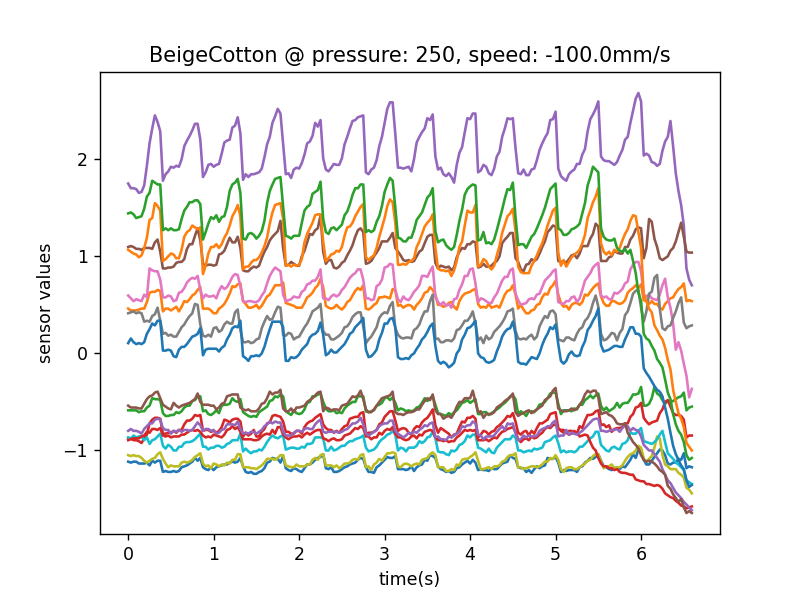

<IPython.core.display.Javascript object>


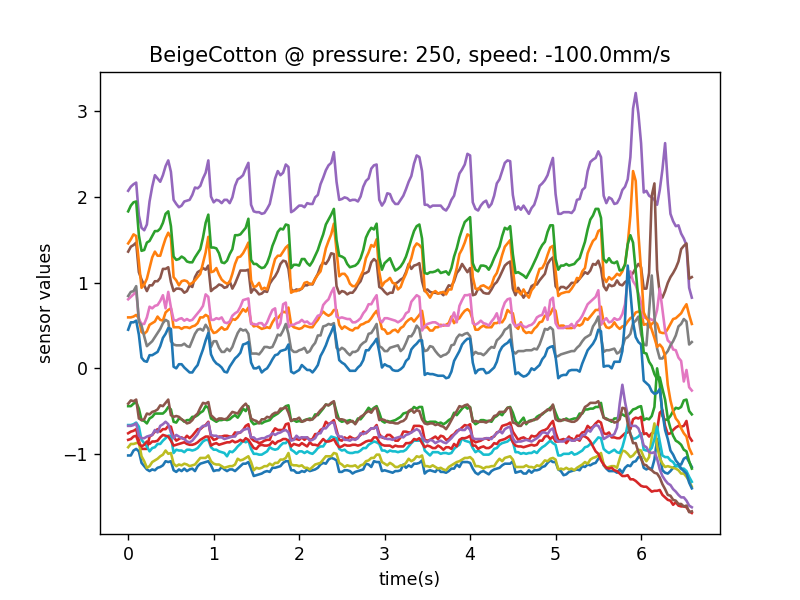

<IPython.core.display.Javascript object>


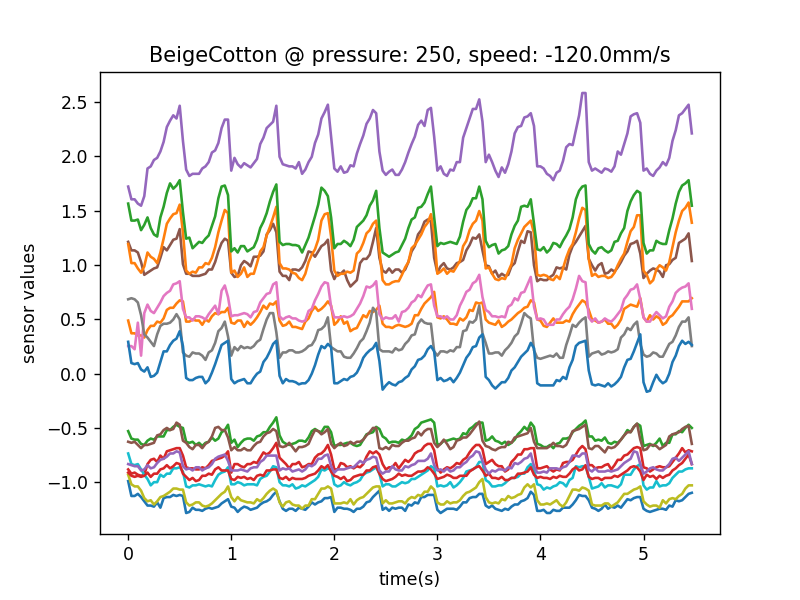

<IPython.core.display.Javascript object>


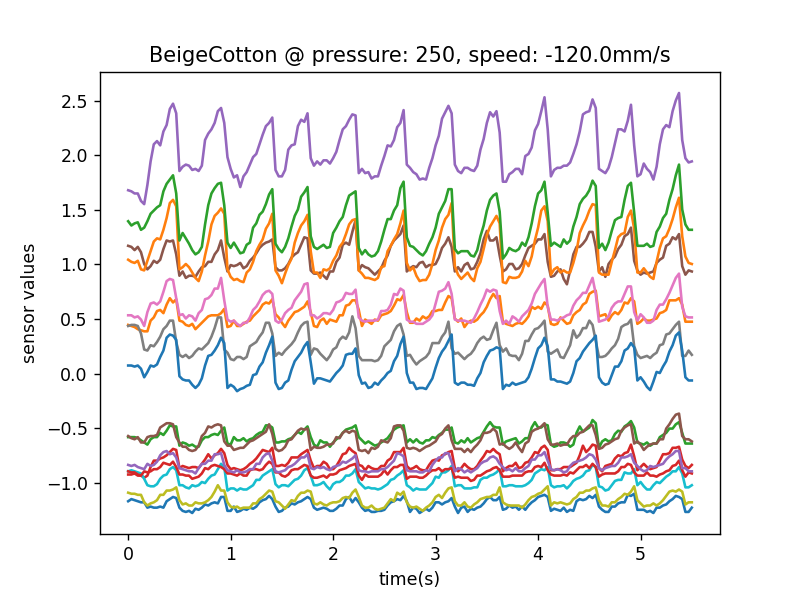

<IPython.core.display.Javascript object>


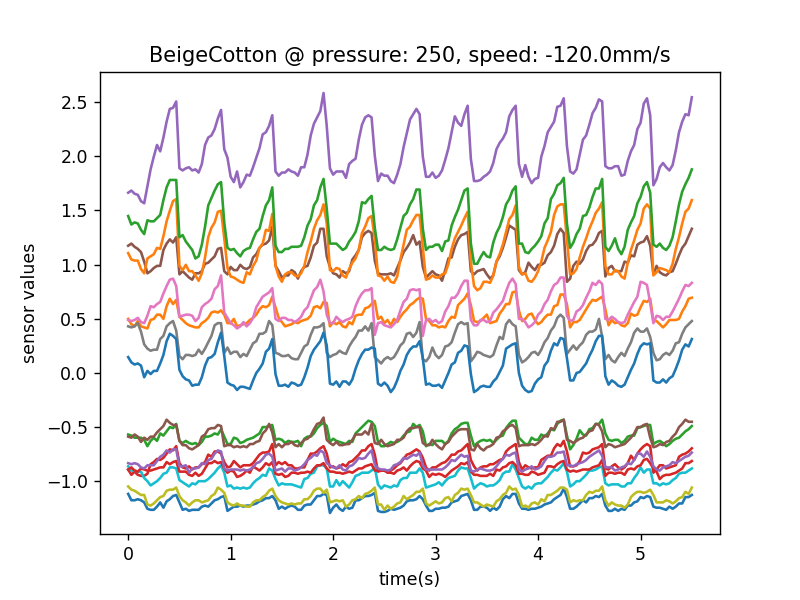

<IPython.core.display.Javascript object>


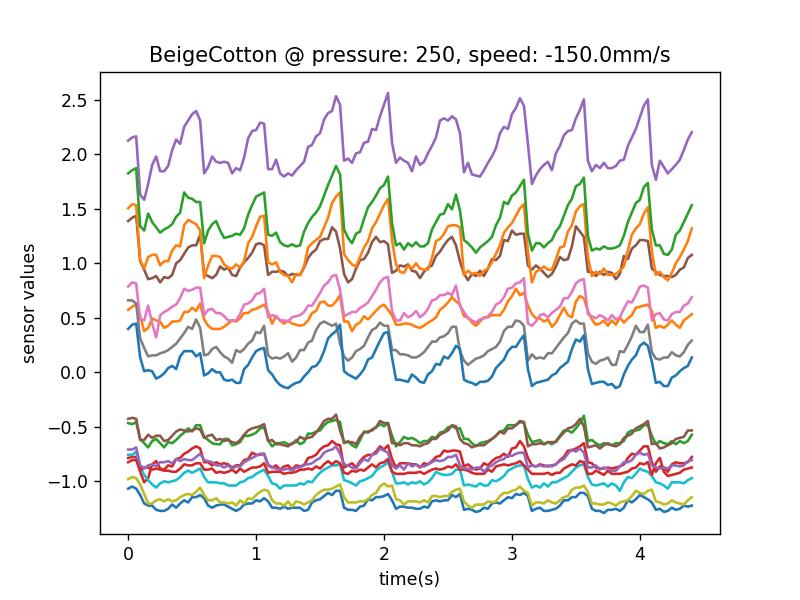

<IPython.core.display.Javascript object>


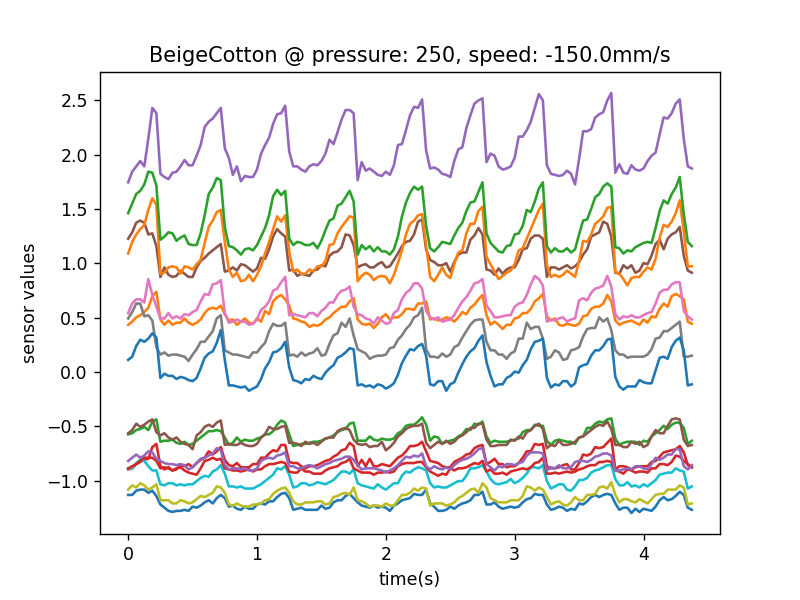

<IPython.core.display.Javascript object>


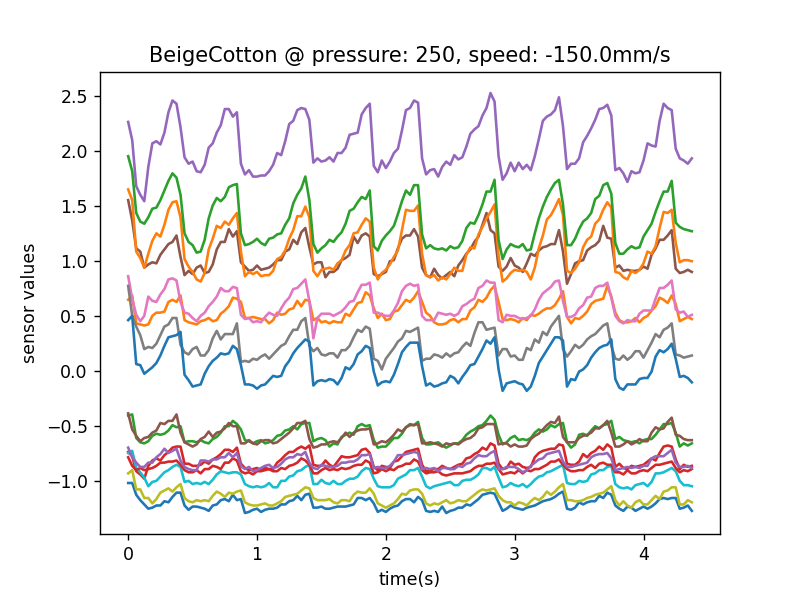

<IPython.core.display.Javascript object>


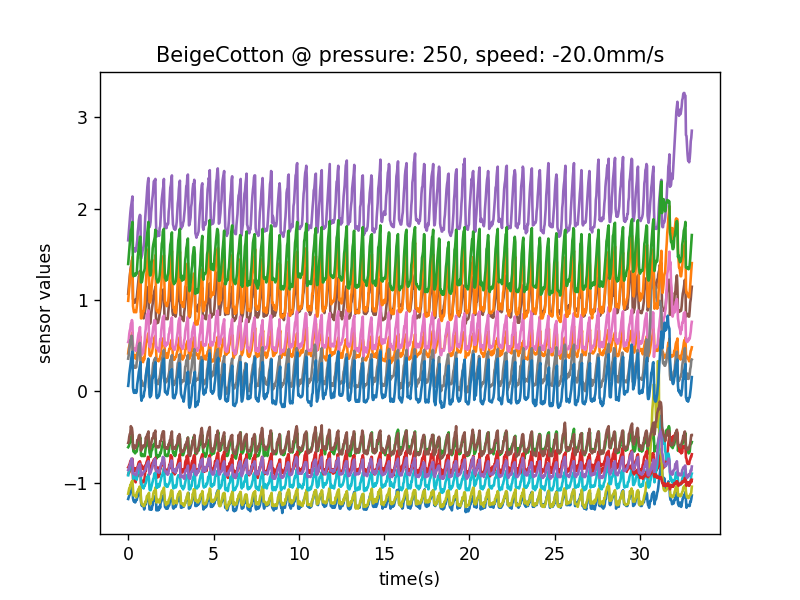

<IPython.core.display.Javascript object>


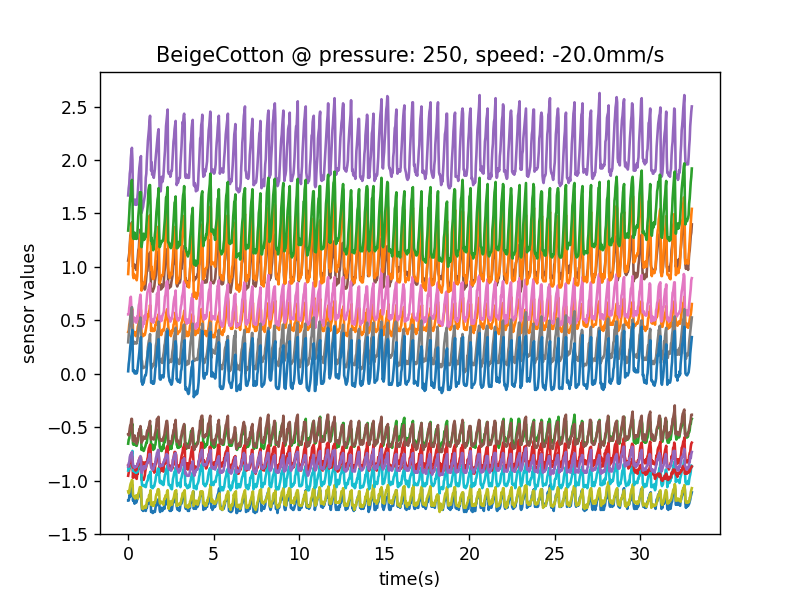

<IPython.core.display.Javascript object>


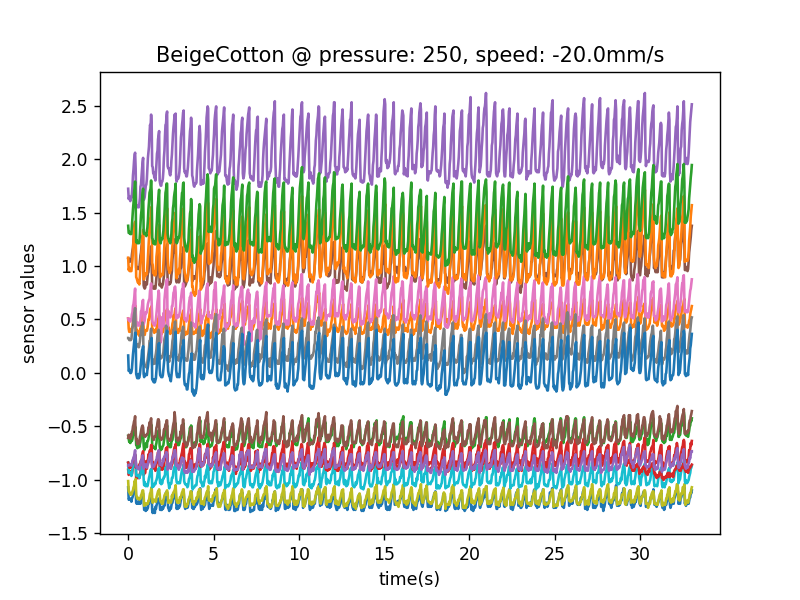

<IPython.core.display.Javascript object>


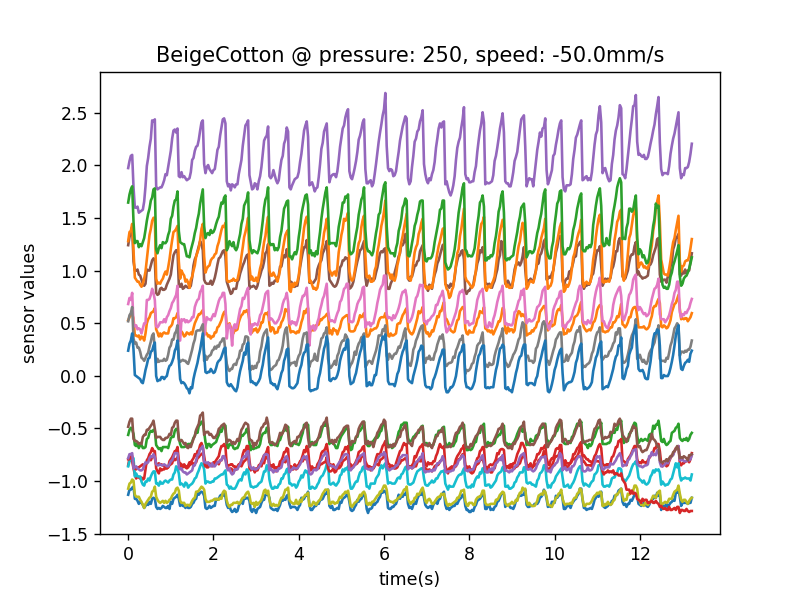

<IPython.core.display.Javascript object>


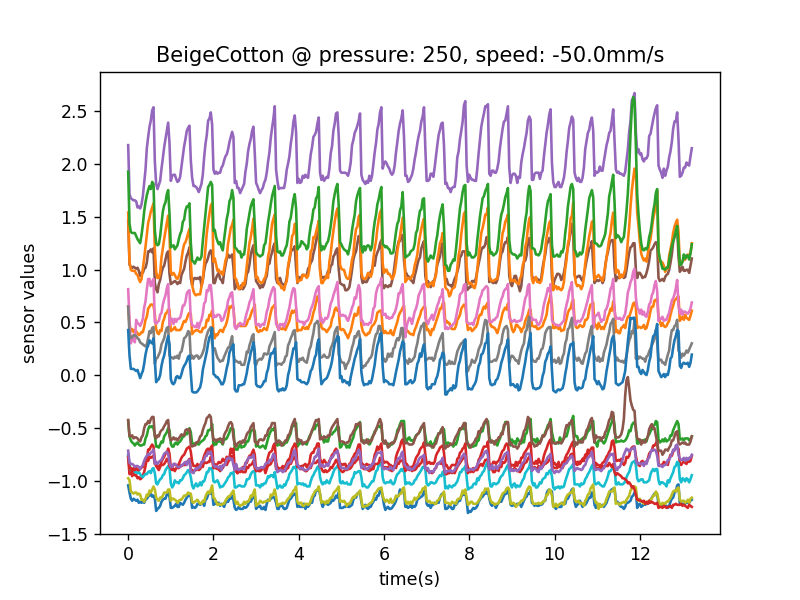

<IPython.core.display.Javascript object>


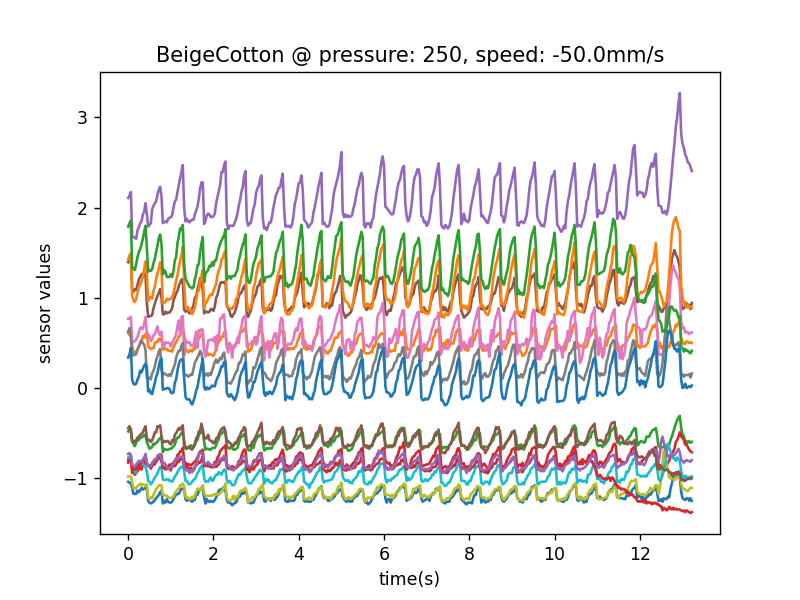

'\nplt.figure()\nplt.plot(x2, y.reshape((-1, 16)))\nplt.xticks([i+1 for i in (0, 32, 4)] + [32])\nplt.xlabel("frequency(Hz)")\nplt.ylabel("strength")\nplt.title("{} @ pressure: {}, speed: {}mm/s".format(ds.get_texture_name(label), param[0], param[1]))\nplt.show()\n'

In [28]:
import matplotlib.pyplot as plt

%matplotlib notebook

for i in range(len(ds)):
    sample, param, label = ds[i]
    if param[0] == 250 and param[1] < -10 and ds.get_texture_name(label) == "BeigeCotton":
        y = fft_resample(sample)
        x1 = np.tile(np.arange(sample.shape[0]).reshape((-1, 1))/32.0, (1, 16))
        x2 = np.tile((np.arange(32)).reshape((-1, 1))+1, (1, 16))

        plt.figure()
        plt.plot(x1, sample)
        plt.ylabel("sensor values")
        plt.xlabel("time(s)")
        plt.title("{} @ pressure: {}, speed: {}mm/s".format(ds.get_texture_name(label), param[0], param[1]))

"""
plt.figure()
plt.plot(x2, y.reshape((-1, 16)))
plt.xticks([i+1 for i in (0, 32, 4)] + [32])
plt.xlabel("frequency(Hz)")
plt.ylabel("strength")
plt.title("{} @ pressure: {}, speed: {}mm/s".format(ds.get_texture_name(label), param[0], param[1]))
plt.show()
"""

# Iterative PCA

## Methods
1. Resample the time series to the same length and transform into frequency domain
2. Flatten the $Ns \times 16$ frequency matrix into a 1D vector
3. Stack the frequency vectors into a frequency matrix

## Steps
1. Use few samples as a prior knowledge to train a PCA compressor ($Ns \times 16$D $\rightarrow 3$D)
2. For new samples, update the de-meaned frequency matrix
3. Apply iterative PCA to update the compressed frequency vector
4. Try to identify the fabric material under current *pressure* and *speed* settings

In [4]:
import pandas as pd
from numpy.fft import rfft
from scipy import signal

num = 64

# prepare data
coeff_array = []
labels = []

for i, (sample, param, label) in enumerate(ds):
    coeffs = fft_resample(sample)
    coeff_array.append(coeffs)
    # append label info
    texture, (p, s) = ds.get_texture_name(label), param
    labels.append((texture, label, p, s))

df0 = pd.DataFrame(labels, columns=["texture", "id", "pressure", "speed"])
coeffs = np.asarray(coeff_array)

In [223]:
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import accuracy_score,confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

%matplotlib notebook

def plot3d(df, items):
    unique_item = df0[items].unique()
    cmap = plt.cm.get_cmap("Paired", len(unique_item))
    colors = dict([(unique_item[i], cmap(i)) for i in range(len(unique_item))])
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    for item in df[items].unique():
        df_ = df[df[items] == item]
        color = np.asarray(colors[item])
        ax.scatter(df_["x"], df_["y"], df_["z"], marker="x", s=20, c=np.tile(color, (len(df_), 1)), label=item)
    ax.legend()
    plt.tight_layout()
    
    return ax

def extractXd(n_components=3, use_texture=2):
    # split textures into (train, test and other) 3 groups
    all_fabrics = df0[~df0["texture"].str.contains("Board")]["texture"].unique()
    np.random.shuffle(all_fabrics)

    tmp = all_fabrics[:use_texture]
    train_id = df0[df0["texture"].isin(tmp)].index
    train_label = df0.iloc[train_id]
    train_coeff = coeffs[train_id, :]

    tmp = all_fabrics[use_texture:]
    test_id = df0[df0["texture"].isin(tmp)].index
    test_label = df0.iloc[test_id]
    test_coeff = coeffs[test_id, :]

    tmp = df0[df0["texture"].str.contains("Board")]["texture"].unique()
    other_id = df0[df0["texture"].isin(tmp)].index
    other_label = df0.iloc[other_id]
    other_coeff = coeffs[other_id, :]
    
    # prepare a feature extractor(transformer) and classifier
    transformer = IncrementalPCA(n_components=n_components)

    # apply incremental PCA on train data
    transformer.partial_fit(train_coeff)
    trainXd = transformer.transform(train_coeff)
    
    return transformer, trainXd, train_label, test_coeff, test_label, other_coeff, other_label

reps = 3
rate = np.zeros((reps, 10))
var_ratio = np.zeros((reps, 10))
for i in range(10):
    for j in range(reps):
        transformer, trainXd, train_label, test_coeff, test_label, other_coeff, other_label = extractXd(i+1)
        var_ratio[j, i] = np.sum(transformer.explained_variance_ratio_[:i+1])
        testXd = transformer.transform(test_coeff)
        allXd = np.vstack([trainXd, testXd])
        allLabel = np.hstack([train_label["id"].values, test_label["id"].values])
        # Convert label to 1-hot array
        h = np.zeros((allLabel.size, allLabel.max()+1))
        h[np.arange(allLabel.size),allLabel] = 1
        
        clf = KNeighborsClassifier(10, weights="distance")
        X_train, X_test, Y_train, Y_test = train_test_split(allXd, h, test_size=0.5, random_state=42)
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        rate[j, i] = accuracy_score(Y_test, Y_pred)

<IPython.core.display.Javascript object>


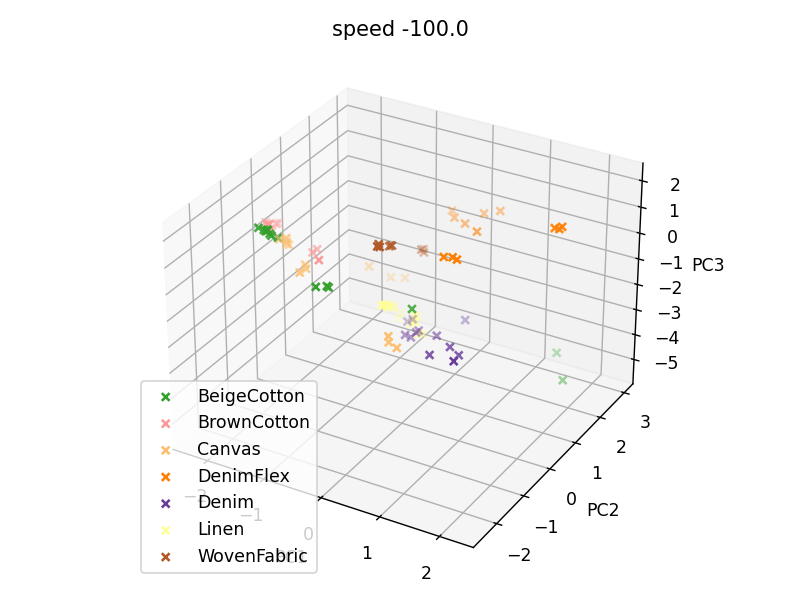

BeigeCotton 0.9951913481638712
BrownCotton 0.9689132485899519
Canvas 0.9934411485314935
DenimFlex 0.9601590931402239
Denim 0.7653717505582752
Linen 0.7553730921853384
WovenFabric 0.9711518734744408


<IPython.core.display.Javascript object>


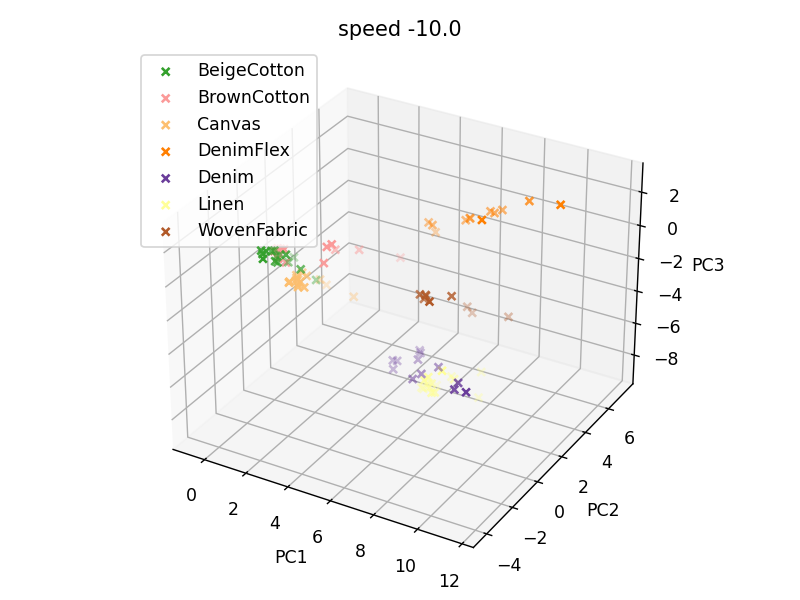

BeigeCotton 0.8593670180220787
BrownCotton 0.7017548939145946
Canvas 0.8988910227170954
DenimFlex 0.8921196242449636
Denim 0.8035067812998262
Linen 0.17638506155630562
WovenFabric 0.9052483342351421


<IPython.core.display.Javascript object>


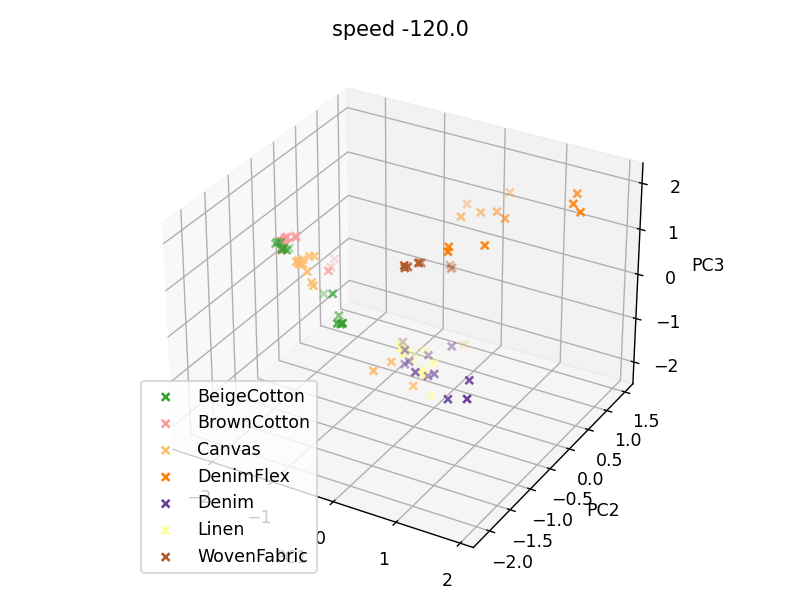

BeigeCotton 0.9799882803629809
BrownCotton 0.9701968635627698
Canvas 0.991405924102382
DenimFlex 0.9407164456274301
Denim 0.5307742062993792
Linen 0.6897658574658772
WovenFabric 0.8603140292907424


<IPython.core.display.Javascript object>


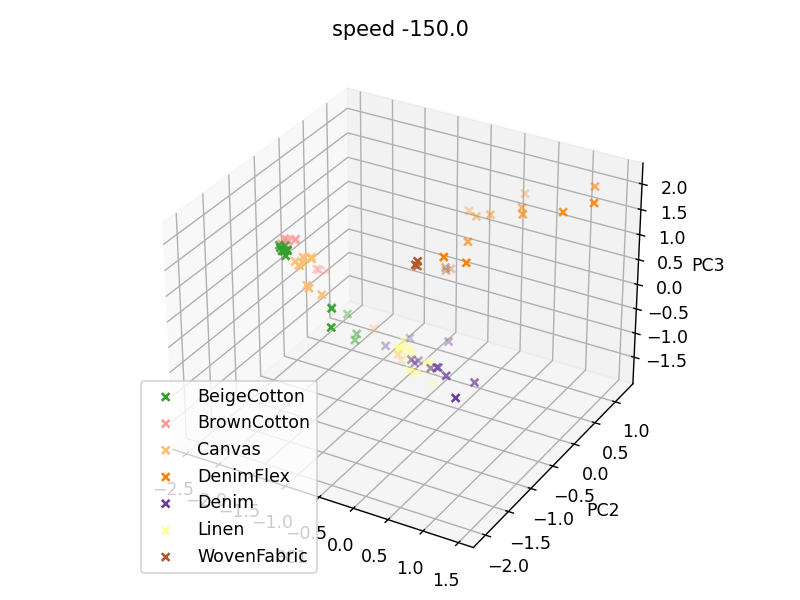

BeigeCotton 0.9866175575711263
BrownCotton 0.9681035230400892
Canvas 0.9877827705603041
DenimFlex 0.9686373656466774
Denim 0.5536168060812504
Linen 0.7632301890473294
WovenFabric 0.8992626201981271


<IPython.core.display.Javascript object>


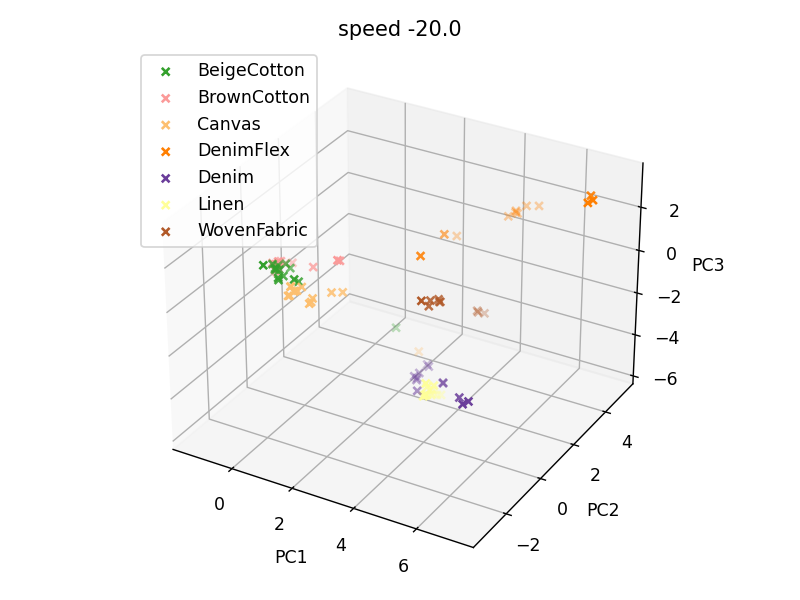

BeigeCotton 0.976584124574237
BrownCotton 0.24689402536246718
Canvas 0.8883929262443805
DenimFlex 0.9738796977224103
Denim 0.807985136711787
Linen 0.6333575914556344
WovenFabric 0.9552008386360504


<IPython.core.display.Javascript object>


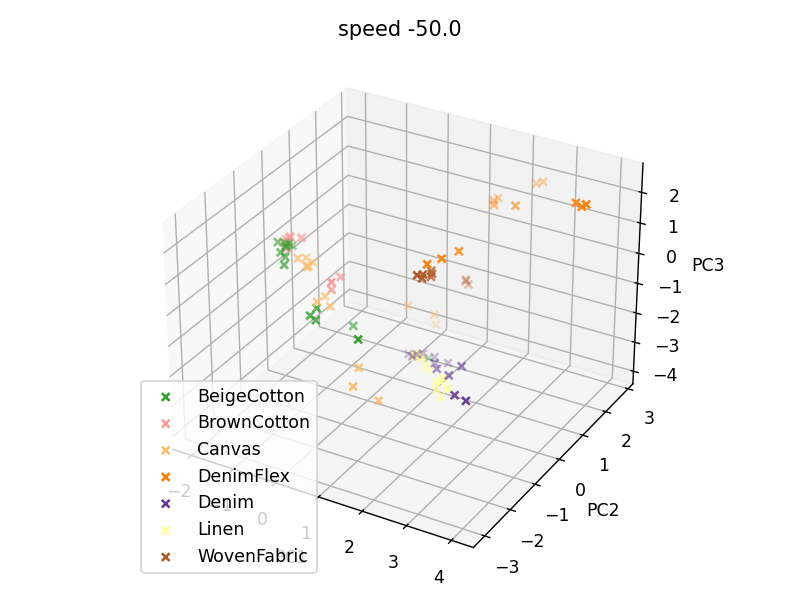

BeigeCotton 0.9742252707102648
BrownCotton 0.9290214154168223
Canvas 0.9734434099368143
DenimFlex 0.9831030160178198
Denim 0.46725281841856225
Linen 0.7324089728270569
WovenFabric 0.9763026449535233


<IPython.core.display.Javascript object>


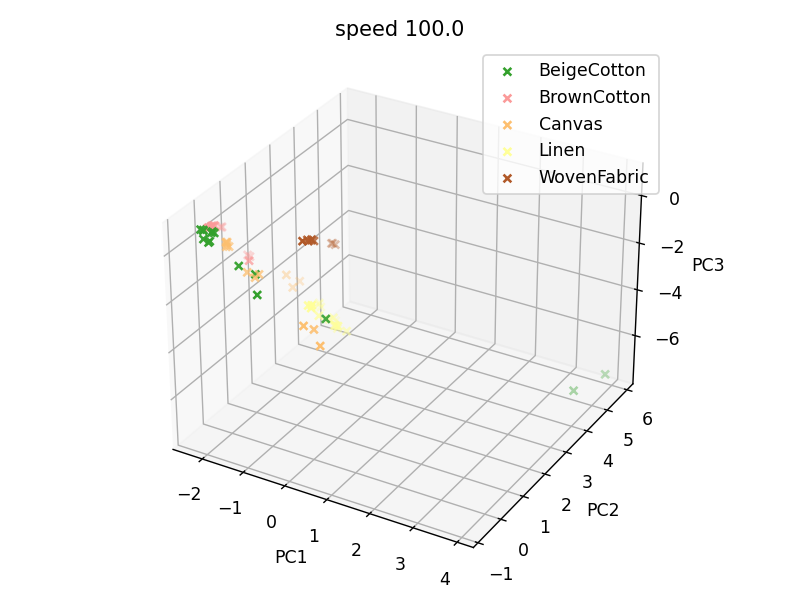

BeigeCotton 0.9984111542892266
BrownCotton 0.9949915247188097
Canvas 0.990987272894294
Linen 0.9224063002962571
WovenFabric 0.970344840983133


<IPython.core.display.Javascript object>


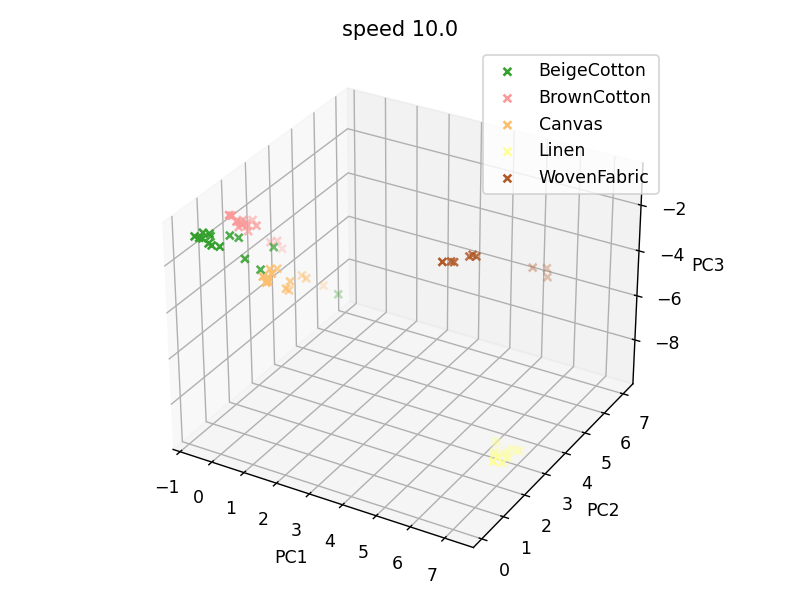

BeigeCotton 0.9379029447388781
BrownCotton 0.9125968938249951
Canvas 0.8093380081496182
Linen 0.3940654681008833
WovenFabric 0.9233731617543753


<IPython.core.display.Javascript object>


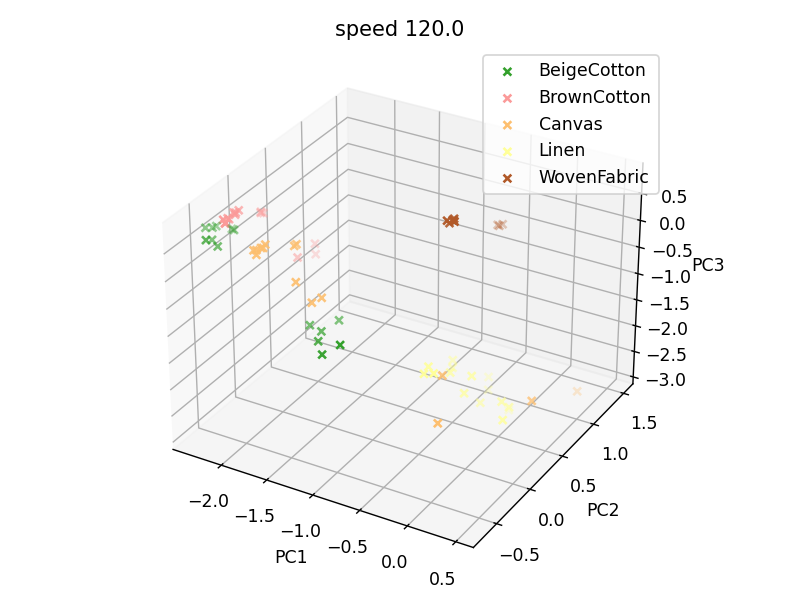

BeigeCotton 0.9824799329684956
BrownCotton 0.9685694086779959
Canvas 0.9759104809430651
Linen 0.8711024025010898
WovenFabric 0.9608507764834775


<IPython.core.display.Javascript object>


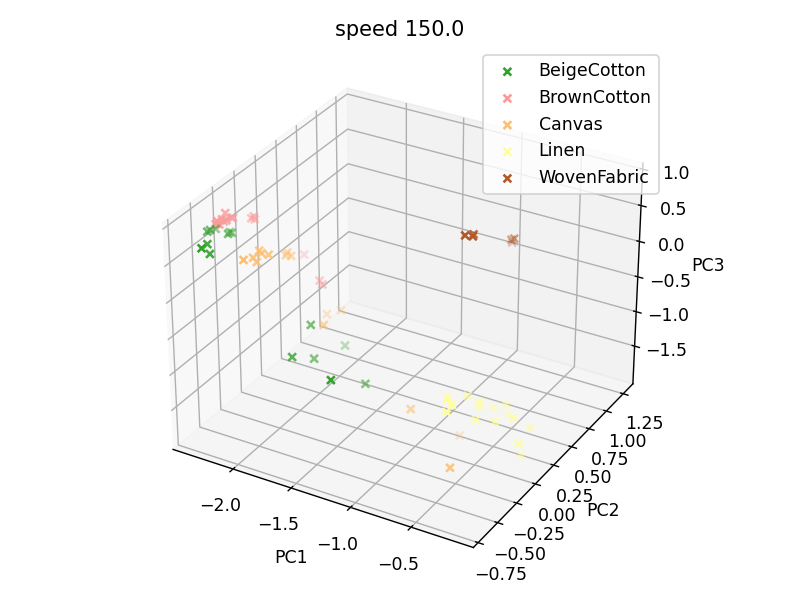

BeigeCotton 0.985974669003661
BrownCotton 0.9887867215605978
Canvas 0.9929159663223711
Linen 0.7715401602265634
WovenFabric 0.9627554319399


<IPython.core.display.Javascript object>


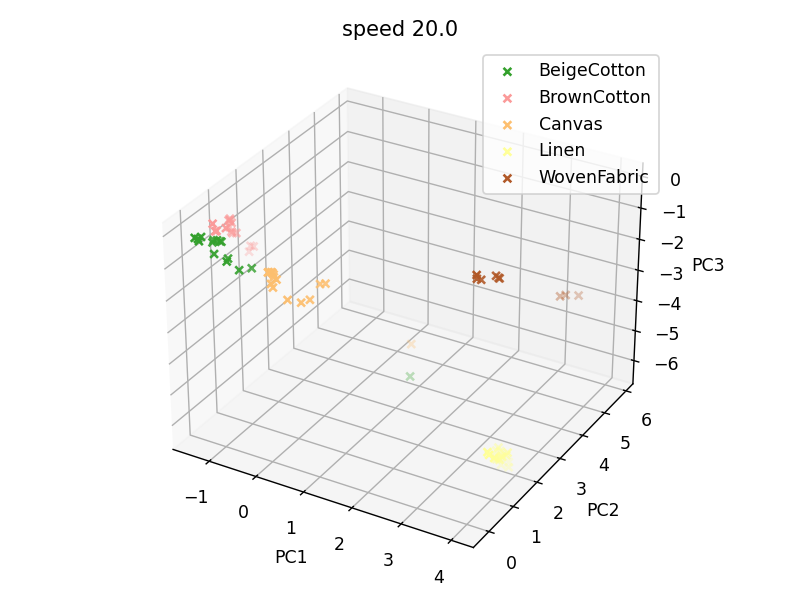

BeigeCotton 0.9949824082796238
BrownCotton 0.8232860145446166
Canvas 0.8705173924532504
Linen 0.6896146251530549
WovenFabric 0.9851067080893744


<IPython.core.display.Javascript object>


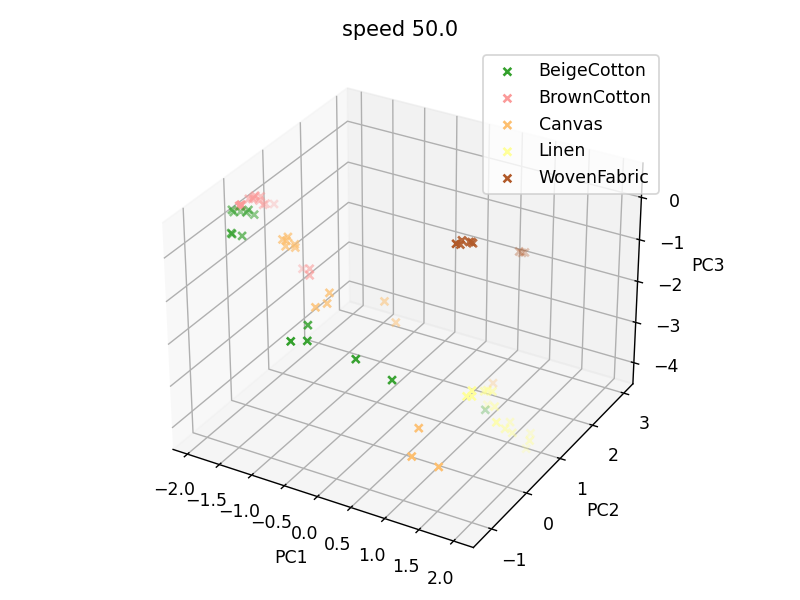

BeigeCotton 0.9761692247107882
BrownCotton 0.9772448441927388
Canvas 0.9922332785137433
Linen 0.9004273355187623
WovenFabric 0.9731343524586709


In [228]:
from sklearn.linear_model import LinearRegression

transformer, trainXd, train_label, test_coeff, test_label, other_coeff, other_label = extractXd(3, 4)
coeffXd = transformer.transform(coeffs)
df1 = pd.DataFrame(coeffXd, columns=["x", "y", "z"])
df = pd.concat([df0, df1], axis=1)

option = "speed"
df["speed"] = pd.abs(df["speed"])
df = df[~df["texture"].str.contains("Board")]
for p in df[option].unique():
    df_ = df[df[option] == p]
    ax = plot3d(df_, "texture")
    for tex in df_["texture"].unique():
        dfx = df_[df_["texture"] == tex]
        X, y = dfx[["x", "y"]], dfx["z"]
        ols = LinearRegression()
        ols.fit(X, y)
        print(tex, ols.score(X, y))
    plt.title("{} {}".format(option, p))
    plt.tight_layout()

<IPython.core.display.Javascript object>


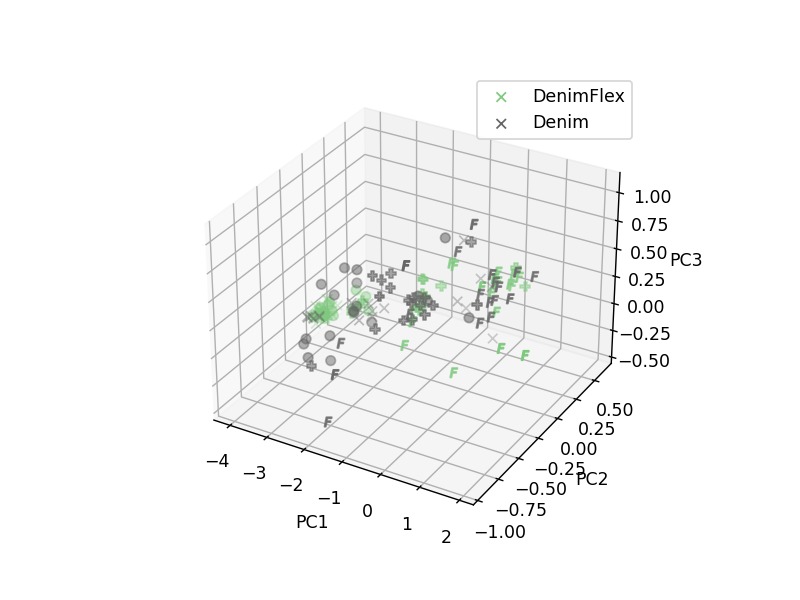

In [195]:
def mscatter(x,y,z, ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    ax = ax or plt.gca()
    sc = ax.scatter(x,y,z,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

transformer, trainXd, train_label, test_coeff, test_label, other_coeff, other_label = extractXd(3)
testXd = transformer.transform(test_coeff)
df1 = pd.DataFrame(np.vstack([trainXd, testXd]), columns=["x", "y", "z"])
df = pd.concat([df0, df1], axis=1)
df_denims = df[df["texture"].str.contains("Denim")]

marker = dict({120: "x", 150: "o", 180: "P", 210: "$F$"})

denims = df_denim["texture"].unique()
cmap = plt.cm.get_cmap("Accent", len(denims))
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
for i, denim in enumerate(denims):
    dd = df_denims[df_denims["texture"] == denim]
    marker_list = list(map(lambda x: marker[x], dd["pressure"]))
    mscatter(dd["x"], dd["y"], dd["z"], ax=ax, m=marker_list, s=30, c=np.tile(cmap(i), (len(dd), 1)), label=denim)
ax.legend()
plt.show()

<IPython.core.display.Javascript object>


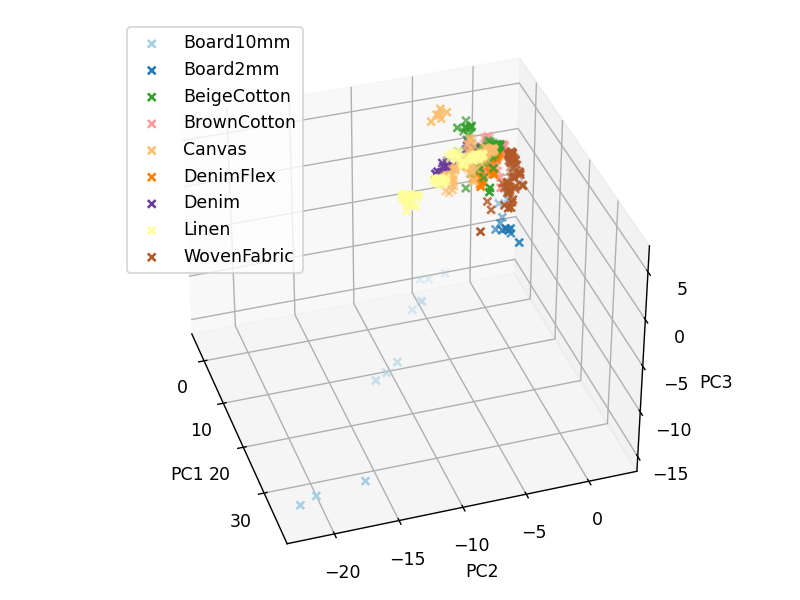

<IPython.core.display.Javascript object>


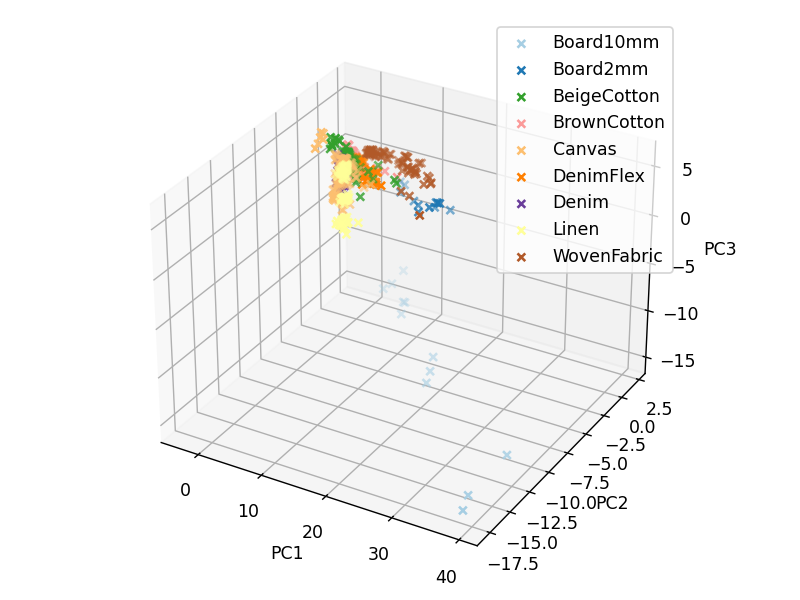

<IPython.core.display.Javascript object>


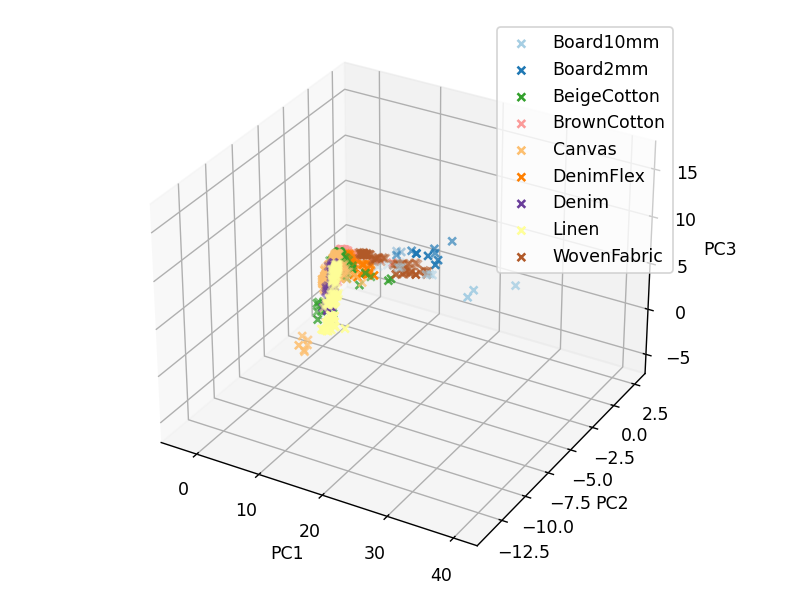

<IPython.core.display.Javascript object>


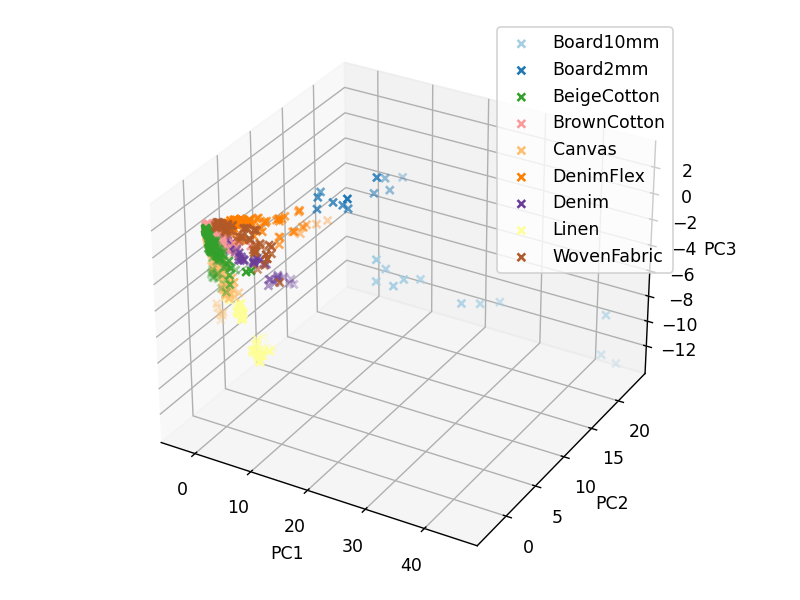

<IPython.core.display.Javascript object>


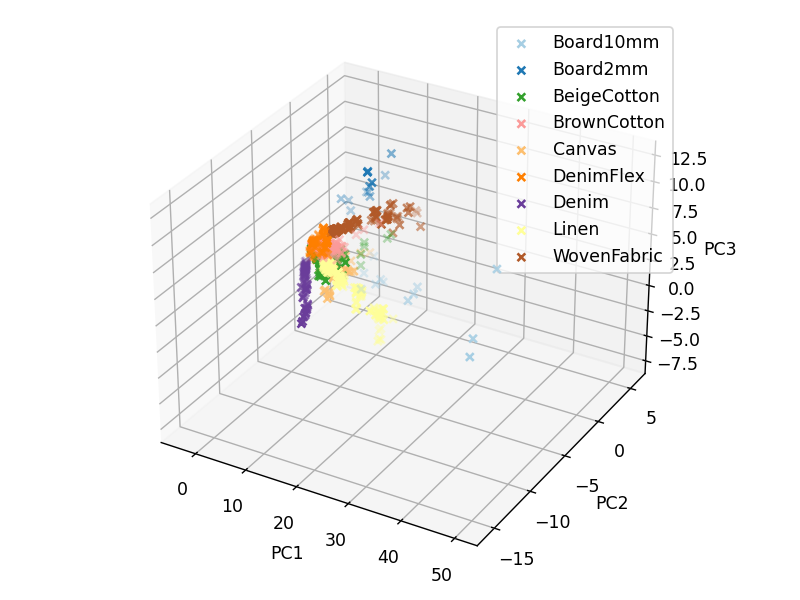

<IPython.core.display.Javascript object>


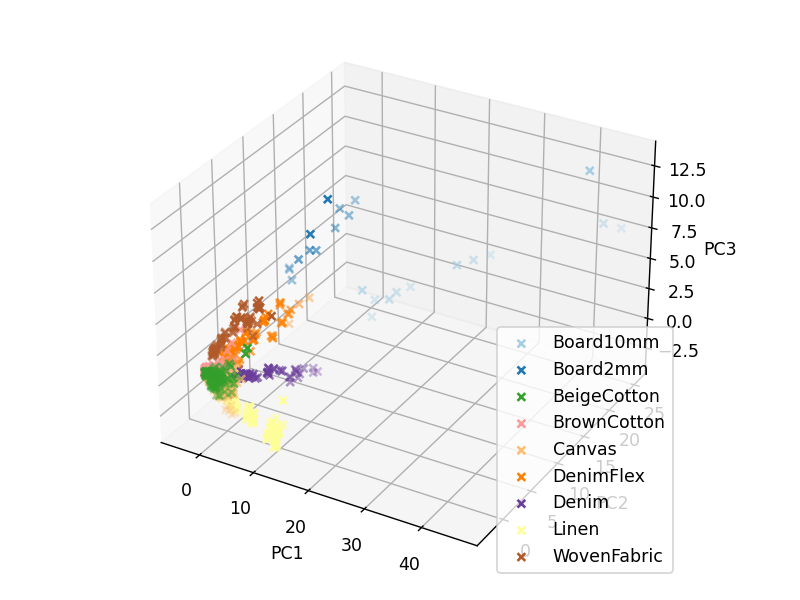

In [204]:
transformer, trainXd, train_label, test_coeff, test_label, other_coeff, other_label = extractXd(3)

coeff_splits = np.array_split(test_coeff, 5, axis=0)
coeffXd = transformer.transform(coeffs)
df1 = pd.DataFrame(coeffXd, columns=["x", "y", "z"])
df = pd.concat([df0, df1], axis=1)
    
plot3d(df, "texture")
for coeff in coeff_splits:
    transformer.partial_fit(coeff)
    coeffXd = transformer.transform(coeffs)
    df1 = pd.DataFrame(coeffXd, columns=["x", "y", "z"])
    df = pd.concat([df0, df1], axis=1)
    
    plot3d(df, "texture")

<IPython.core.display.Javascript object>


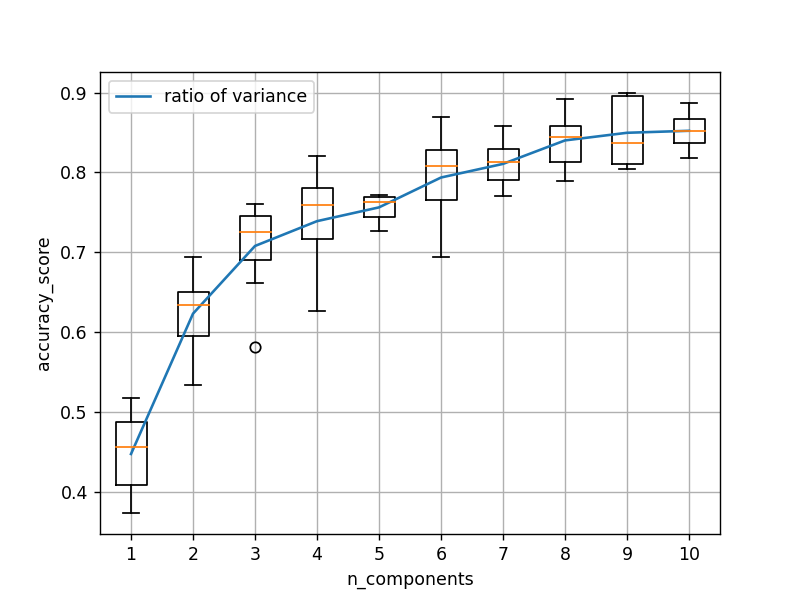

In [133]:
plt.figure()
plt.boxplot(var_ratio)
plt.plot(np.arange(10)+1, np.mean(var_ratio, axis=0), label='ratio of variance')
plt.grid()
plt.xlabel("n_components")
plt.ylabel("accuracy_score")
plt.legend()

# Construct RNN-AutoEncoder (RAE)

In [184]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence


class Encoder(nn.Module):
    """ Recurent Variational Autoencoder """
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, device, dropout=0.3):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.device = device
        
        self.rnn = nn.GRU(input_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, output_dim)
        self.fc_var = nn.Linear(hidden_dim, output_dim)
        
        self.to(device)
        
    def forward(self, x):
        packed_in = pack_padded_sequence(x[0].to(self.device), x[1].cpu().numpy(), batch_first=True)
        rnn_out, self.hidden = self.rnn(packed_in)
        x_in = self.hidden[-1].squeeze()
        mu = self.fc_mu(x_in)
        var = self.fc_var(x_in)
        
        return mu
    
    def init_hidden(self, batch_dim):
        return (torch.zeros(self.n_layers, batch_dim, self.hidden_dim, device=self.device),
                torch.zeros(self.n_layers, batch_dim, self.hidden_dim, device=self.device))


class RVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, encoding_dim, extra_dim, output_dim, n_layers, device):
        super(RVAE, self).__init__()
        self.device = device
        
        self.encoder = Encoder(input_dim, hidden_dim, encoding_dim, n_layers, device)
        self.classifier = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
            nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        encoded = self.encode(x[:2])
        # x_in = torch.hstack([encoded, x[2].to(self.device)])
        y = self.classifier(encoded)

        return y

    def encode(self, x):
        return self.encoder(x)
    
""" Custom collate functions"""

class PadSequence(object):
    def __call__(self, batch):
        # Each element in "batch" is a tuple (data, label).
        # Sort the batch in the descending order
        sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
        # Get each sequence and pad it
        sequences = [torch.tensor(x[0], dtype=torch.float) for x in sorted_batch]
        sequences_padded = pad_sequence(
            sequences, batch_first=True)
        # Store the length of each sequence
        lengths = torch.tensor([len(x) for x in sequences])
        params = torch.tensor(list(map(lambda x: x[1], sorted_batch)), dtype=torch.float)
        labels = torch.tensor(list(map(lambda x: x[2], sorted_batch)))
        return sequences_padded, lengths, params, labels

# Train the network

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch import optim
from torch.utils.data import DataLoader

BATCH_SIZE = 8
EPOCHS = 10
INPUT_DIM = 16
NUM_CLASS = ds.count_class()

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

train_loader = DataLoader(ds, batch_size=BATCH_SIZE, collate_fn=PadSequence(), num_workers=6, shuffle=True)
rvae = RVAE(input_dim=INPUT_DIM, hidden_dim=16, encoding_dim=3, extra_dim=2, output_dim=NUM_CLASS, n_layers=3, device=device)
loss_list = []

def train_once(x, y, model, optimizer, criterion):
    optimizer.zero_grad()
    output = model(x)
    target = y.to(device)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    
    return loss.item()
    
def train_model(data_loader, model):
    optimizer = optim.SGD(model.parameters(), lr = 1e-3)
    criterion = nn.CrossEntropyLoss()
    # loss_list = []
    
    for epoch in range(EPOCHS):
        running_loss = 0.0
        
        for i, (batch, lengths, params, targets) in enumerate(data_loader):
            loss = train_once((batch, lengths, params), targets, model, optimizer, criterion)
            running_loss += loss
            loss_list.append(loss)
            
            if i % 10 == 9:
                print('Epoch {}, {:.2f}% - loss: {:.6f}'.format(epoch + 1, 100.0 * (i + 1.0) / len(data_loader), running_loss / 10))
                running_loss = 0.0
                
    print("Training finished.")
    plt.figure()
    plt.plot(loss_list)
    plt.title("Training Recurrent Autoencoder")
    plt.xlabel("Run")
    plt.ylabel("Loss")
    plt.show()
    
train_model(train_loader, rvae)